# Metric learning for image similarity search

**Author:** [Mat Kelcey](https://twitter.com/mat_kelcey)<br>
**Date created:** 2020/06/05<br>
**Last modified:** 2020/06/09<br>
**Description:** Example of using similarity metric learning on CIFAR-10 images.

## Overview

Metric learning aims to train models that can embed inputs into a high-dimensional space
such that "similar" inputs, as defined by the training scheme, are located close to each
other. These models once trained can produce embeddings for downstream systems where such
similarity is useful; examples include as a ranking signal for search or as a form of
pretrained embedding model for another supervised problem.

For a more detailed overview of metric learning see:

* [What is metric learning?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* ["Using crossentropy for metric learning" tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)


## Setup


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers


## Dataset

For this example we will be using the
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.


In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)


170508288/170498071 [==============================] - 2s 0us/step


To get a sense of the dataset we can visualise a grid of 25 random examples.



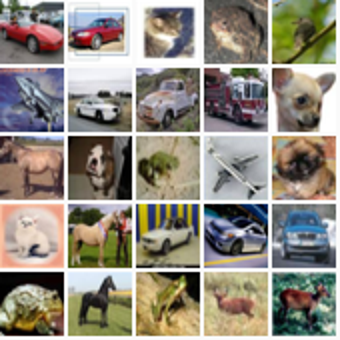

In [3]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)


In [19]:
x_train.shape

(50000, 32, 32, 3)

Metric learning provides training data not as explicit `(X, y)` pairs but instead uses
multiple instances that are related in the way we want to express similarity. In our
example we will use instances of the same class to represent similarity; a single
training instance will not be one image, but a pair of images of the same class. When
referring to the images in this pair we'll use the common metric learning names of the
`anchor` (a randomly chosen image) and the `positive` (another randomly chosen image of
the same class).

To facilitate this we need to build a form of lookup that maps from classes to the
instances of that class. When generating data for training we will sample from this
lookup.


In [4]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)


For this example we are using the simplest approach to training; a batch will consist of
`(anchor, positive)` pairs spread across the classes. The goal of learning will be to
move the anchor and positive pairs closer together and further away from other instances
in the batch. In this case the batch size will be dictated by the number of classes; for
CIFAR-10 this is 10.


In [5]:
num_classes = 10


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x



We can visualise a batch in another collage. The top row shows randomly chosen anchors
from the 10 classes, the bottom row shows the corresponding 10 positives.


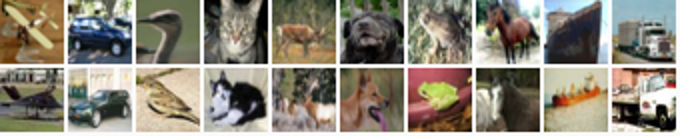

In [6]:
examples = next(iter(AnchorPositivePairs(num_batchs=1)))

show_collage(examples)


In [14]:
examples[0].shape

(10, 32, 32, 3)

## Embedding model

We define a custom model with a `train_step` that first embeds both anchors and positives
and then uses their pairwise dot products as logits for a softmax.


In [7]:

class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            # Calculate cosine similarity between anchors and positives. As they have
            # been normalised this is just the pair wise dot products.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.2
            similarities /= temperature

            # We use these similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}



Next we describe the architecture that maps from an image to an embedding. This model
simply consists of a sequence of 2d convolutions followed by global pooling with a final
linear projection to an embedding space. As is common in metric learning we normalise the
embeddings so that we can use simple dot products to measure similarity. For simplicity
this model is intentionally small.


In [8]:
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)


Finally we run the training. On a Google Colab GPU instance this takes about a minute.


Epoch 1/20
1000/1000 [==============================] - 15s 14ms/step - loss: 2.0166
Epoch 2/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9775
Epoch 3/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9458
Epoch 4/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.9125
Epoch 5/20
1000/1000 [==============================] - 17s 17ms/step - loss: 1.8862
Epoch 6/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8491
Epoch 7/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8290
Epoch 8/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8066
Epoch 9/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.7656
Epoch 10/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.7427
Epoch 11/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.7367
Epoch 12/20
1000/1000 [==============================] - 15s 15

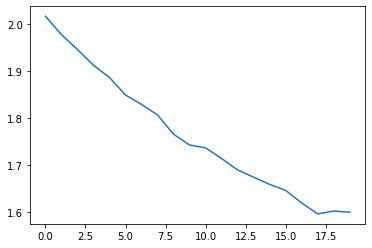

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)

plt.plot(history.history["loss"])
plt.show()


## Testing

We can review the quality of this model by applying it to the test set and considering
near neighbours in the embedding space.

First we embed the test set and calculate all near neighbours. Recall that since the
embeddings are unit length we can calculate cosine similarity via dot products.


In [21]:
near_neighbours_per_example = 10

embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]


As a visual check of these embeddings we can build a collage of the near neighbours for 5
random examples. The first column of the image below is a randomly selected image, the
following 10 columns show the nearest neighbours in order of similarity.


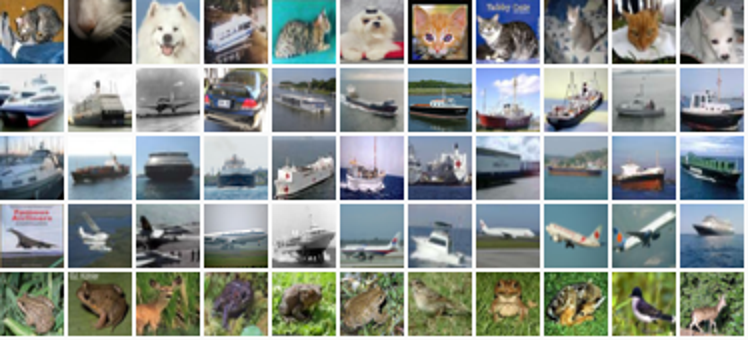

In [22]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)


We can also get a quantified view of the performance by considering the correctness of
near neighbours in terms of a confusion matrix.

Let us sample 10 examples from each of the 10 classes and consider their near neighbours
as a form of prediction; that is, does the example and its near neighbours share the same
class?

We observe that each animal class does generally well, and is confused the most with the
other animal classes. The vehicle classes follow the same pattern.


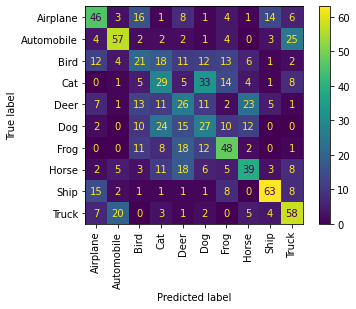

In [23]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()
